# Run this cell first

In [1]:
# this code enables the automated feedback. If you remove this, you won't get any feedback
# so don't delete this cell!
try:
  import AutoFeedback
except (ModuleNotFoundError, ImportError):
  %pip install git+https://github.com/abrown41/AutoFeedback@notebook
  import AutoFeedback

try:
  from testsrc import test_main
except (ModuleNotFoundError, ImportError):
  %pip install "git+https://github.com/autofeedback-exercises/exercises.git@testpip#subdirectory=MTH2021/Radon"
  from testsrc import test_main

try:
  from testsrc.test_main import sheplog
except (ModuleNotFoundError, ImportError):
  print("whoops")
  pass

def runtest(tlist):
  import unittest
  from contextlib import redirect_stderr
  from os import devnull
  with redirect_stderr(open(devnull, 'w')):
    suite = unittest.TestSuite()
    for tname in tlist:
      suite.addTest(eval(f"test_main.UnitTests.{tname}"))
    runner = unittest.TextTestRunner()
    try:
      runner.run(suite)
    except AssertionError:
      pass


# Setup
The code to define the starting image is written for you. The picture is known as Toft's modified Shepp-Logan picture, and the function to make the picture is called `sheplog`. You can build it and plot it to see what you're aiming for by running the code below.

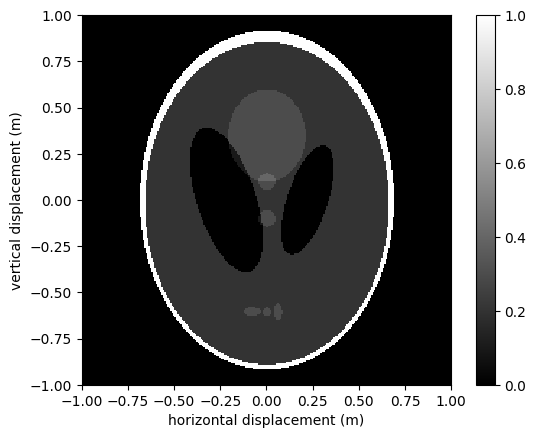

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N= 256 # This defines the dimension of the image: 256X256 pixels
phantom = sheplog(N)
plt.imshow(phantom, cmap='gray', interpolation='none', aspect='equal', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.xlabel('horizontal displacement (m)')
plt.ylabel('vertical displacement (m)')
plt.show()

We also need to build arrays for the coordinates that we will use in the rest of our calculations. Namely

* `grid`: holding `N` linearly spaced grid-values between -1 and 1
* `angles`: holding `M` linearly spaced angle-values between 0 and $\dfrac{(M-1)\pi}{M}$

In [3]:
grid = np.linspace(-1, 1, N)
M = 30
angles = np.linspace(0, np.pi*(M-1)/M, M)

# Radon Transform

The Radon transform is what would actually be measured by the CT scanner. To build this image from our Shepp-Logan image, run the cell below

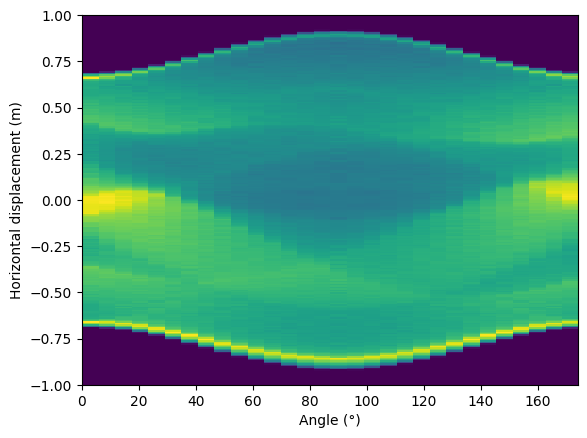

In [4]:
Radon_image = np.zeros((N,M))                

fit_grid = np.zeros((N,2))

for m, angle in enumerate(angles):
    for n, displacement in enumerate(grid):
       fit_grid[:, 0] = np.linspace(-np.cos(angle), np.cos(angle), N)-displacement * np.sin(angle)
       fit_grid[:, 1] = np.linspace(-np.sin(angle), np.sin(angle), N)+displacement * np.cos(angle)
       in_data = scipy.interpolate.interpn((grid, grid), phantom, fit_grid,  method='linear', bounds_error=False, fill_value=0)
       Radon_image[n, m]=sum(in_data) * 2. / N

plt.imshow(Radon_image,interpolation='none',aspect='auto', extent=[0, 174, -1,1])
plt.xlabel('Angle (°)')
plt.ylabel('Horizontal displacement (m)')
plt.show()

# The inverse Radon Transform

Instructions...

In [5]:
dk = np.pi
k_grid=np.zeros(N)
for ii in range(N//2):
    k_grid[ii] = ii*np.pi
    k_grid[N-ii-1] =-(ii+1) * np.pi 

k_grid[N//2] = (N//2)*np.pi

abs_k = np.abs(k_grid)
phase_k = np.exp(-1j*k_grid)

In [6]:
runtest(['test_kgrid', 'test_absk', 'test_phasek'])

Variable k_grid is correct!              


Variable abs_k is correct!              


Variable phase_k is correct!              




More instructions

Note: your doc says to use `np.fft`, but you are using `scipy.fft.fft` here...

In [7]:
Radon_Fourier = np.zeros((N,M), dtype = complex)

dtheta = np.pi/M
angles = np.arange(0, np.pi, dtheta)
for m, angle in enumerate(angles):
    Radon_Fourier[:, m] = scipy.fft.fft(Radon_image[:, m]) * abs_k * phase_k

Radon_Fourier = Radon_Fourier*2/(N*np.sqrt(2*np.pi))

In [8]:
Recon_comp=np.zeros((N,N),dtype=complex)
Recon=np.zeros((N,N))


grid_2d = np.meshgrid(grid,grid)

In [9]:

for m, angle in enumerate(angles):
    print(f'evaluating angle number {m}', end='\r')
    kx = k_grid * np.cos(angle)
    ky = -k_grid * np.sin(angle)
    for n, k in enumerate(k_grid):
      Recon_comp=np.exp(1j*kx[n]*grid_2d[0])*np.exp(1j*ky[n]*grid_2d[1])*Radon_Fourier[n, m]
      Recon += np.real(Recon_comp)/(N*np.pi)


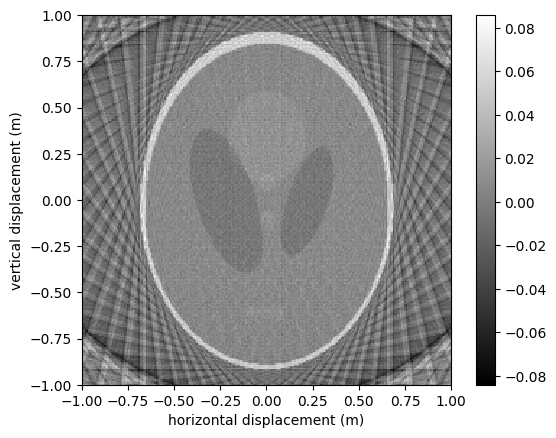

In [10]:

plt.imshow(Recon, interpolation='none', cmap='gray', extent=[-1, 1, -1, 1])
plt.xlabel('horizontal displacement (m)')
plt.ylabel('vertical displacement (m)')
plt.colorbar()
plt.show()



We can set the unreliable part of the figure to some average value and rescale the figure to on a 0 - 1 scale using relevant data only and set the all data outside the area of relevance to 0


In [11]:
Recon = Recon*(np.sqrt(grid_2d[1]**2+grid_2d[0]**2)<=1.) + \
    innerav*(np.sqrt(grid_2d[1]**2+grid_2d[0]**2)>1.)

Reconmx = np.max(Recon)
Reconmin = np.min(Recon)

Recon = (Recon-Reconmin)/(Reconmx-Reconmin) \
    *(np.sqrt(grid_2d[1]**2+grid_2d[0]**2)<=1.)

plt.imshow(Recon,interpolation='none',cmap='gray', extent=[-1, 1, -1, 1])
plt.xlabel('horizontal displacement (m)')
plt.ylabel('vertical displacement (m)')
plt.colorbar()
plt.show()

NameError: name 'innerav' is not defined